# Self-Driving Car Engineer Nanodegree

## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Import Packages

In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Read in an Image

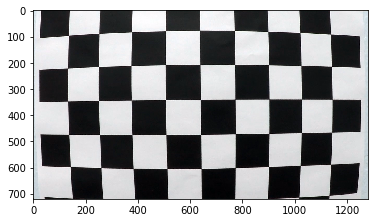

In [2]:
# Distorted image
img = cv2.imread('camera_cal/calibration1.jpg')
plt.imshow(img)

## Find Corners

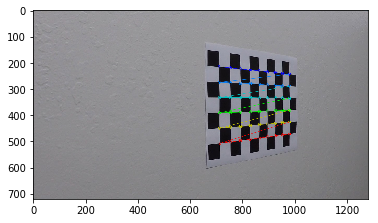

In [3]:
# Calibration Images
images = glob.glob('camera_cal/calibration*.jpg')

nx = 9 # number of inside corners in x
ny = 6 # number of inside corners in y

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Object points
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

# Iterate through all images
for fname in images:
    # Read image
    img = mpimg.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)


## Correct Distortion

In [4]:
# Function takes an image, object points, and image points
# performs the camera calibration, image distortion correction and
# returns the undistorted image, matrix and distortion coefficients
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist

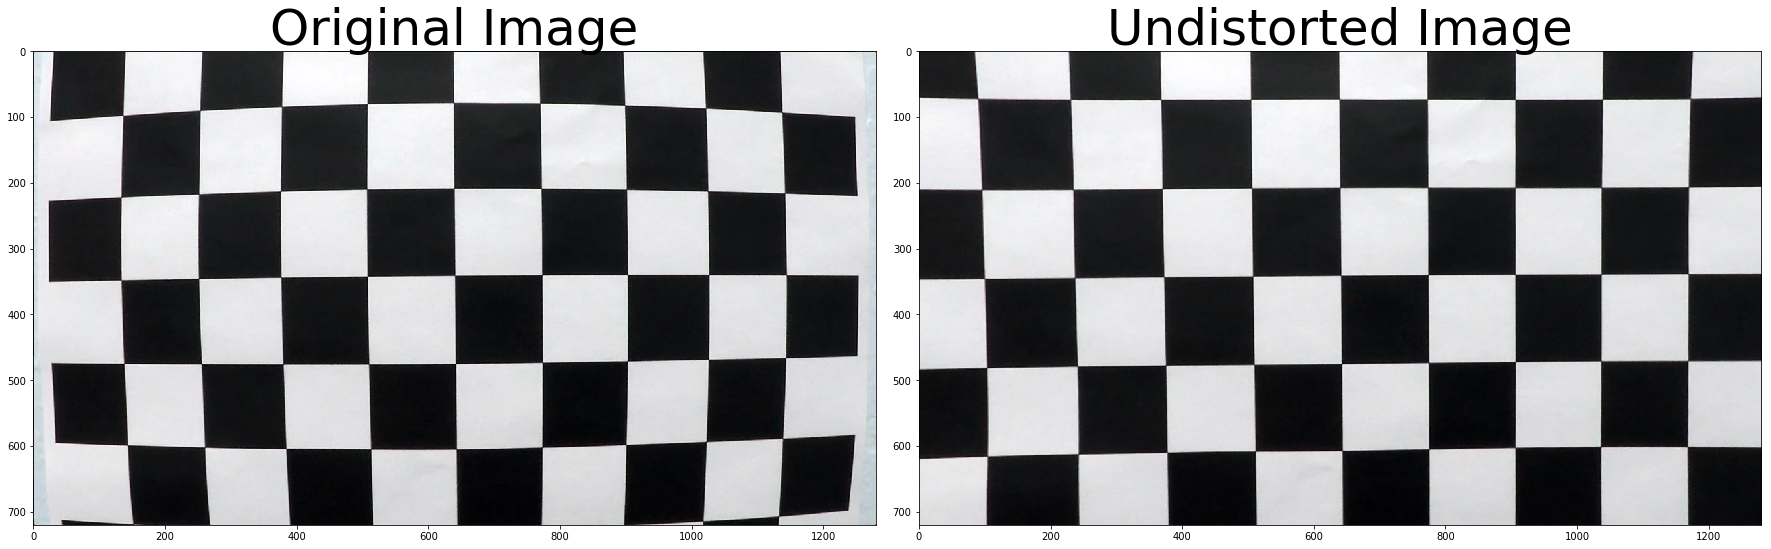

In [5]:
# Read in a distorted image
img = cv2.imread('camera_cal/calibration1.jpg')

undistorted, mtx, dist = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

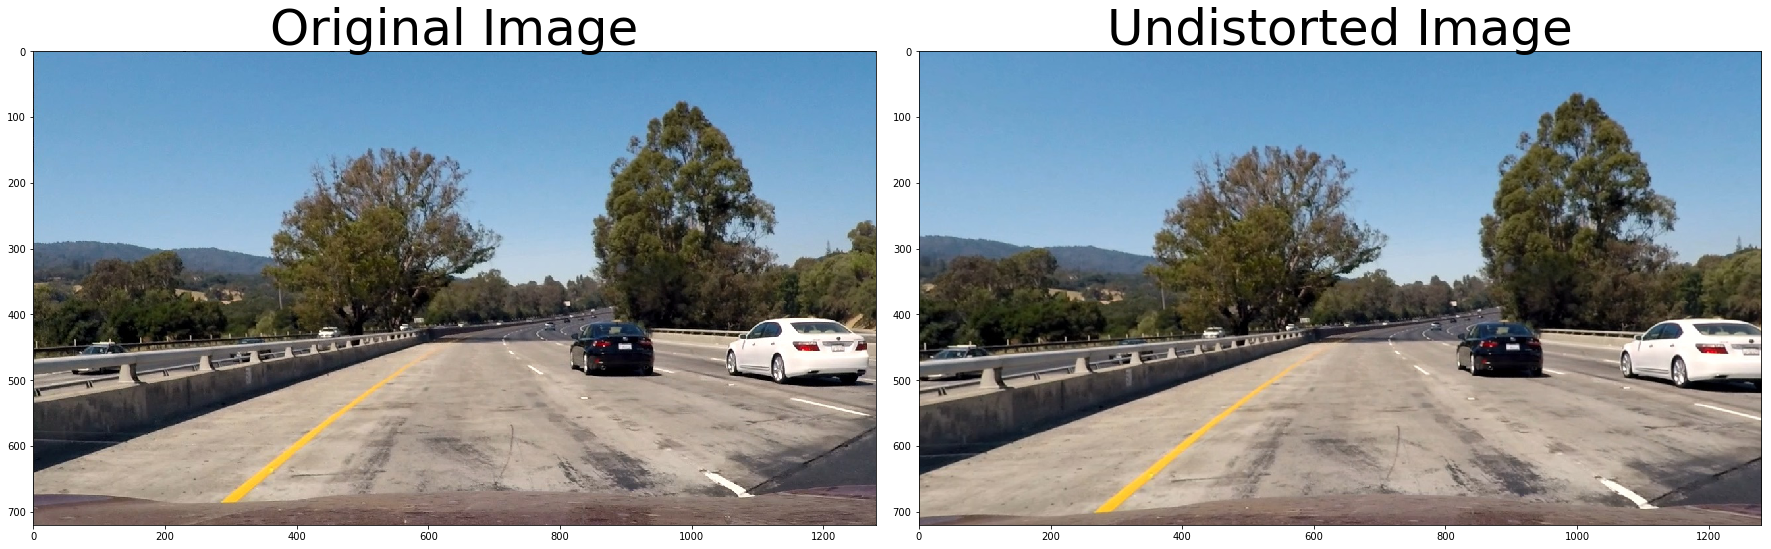

In [6]:
# Read in a distorted image
img = mpimg.imread('test_images/test1.jpg')

undist = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Undistort and Transform Perspective

In [7]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    M = mtx
    warped = img

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)
    else:
        print("Couldn't find corners, printing original image")

    # Return the resulting image and matrix
    return warped, M

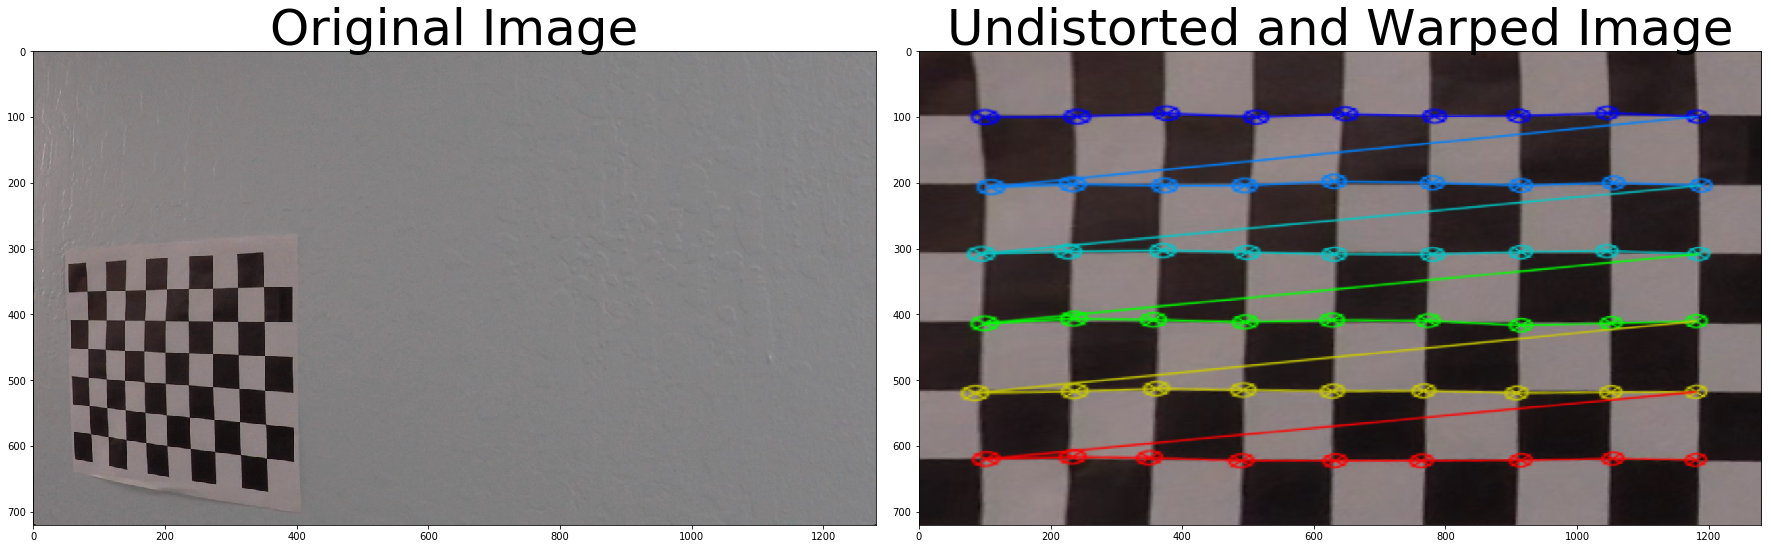

In [8]:
# Read in a distorted image
img = cv2.imread('camera_cal/calibration20.jpg')

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Apply Sobel

In [9]:
# Define a function that applies Sobel x or y,
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Return the result
    return binary_output

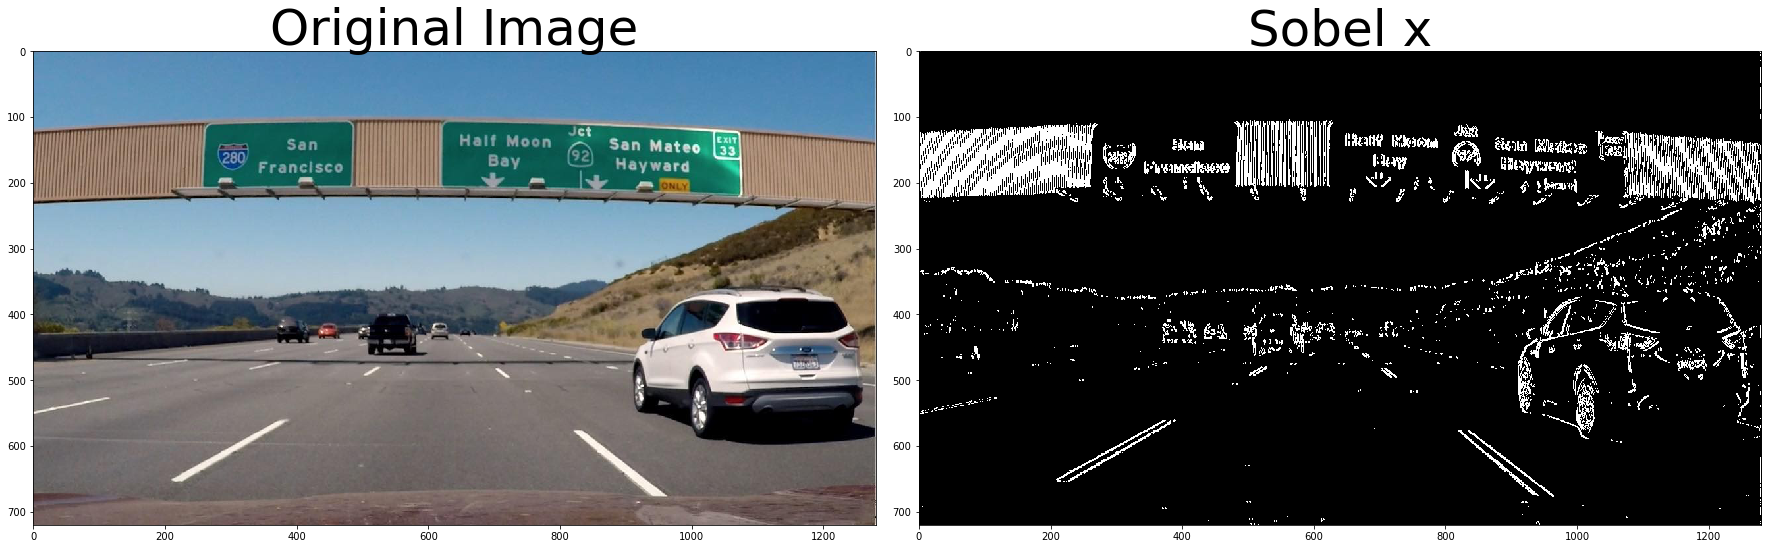

In [10]:
# Read in an image
image = mpimg.imread('test_images/signs_vehicles_xygrad.png')

# Run the function, x orientation
grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Sobel x', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

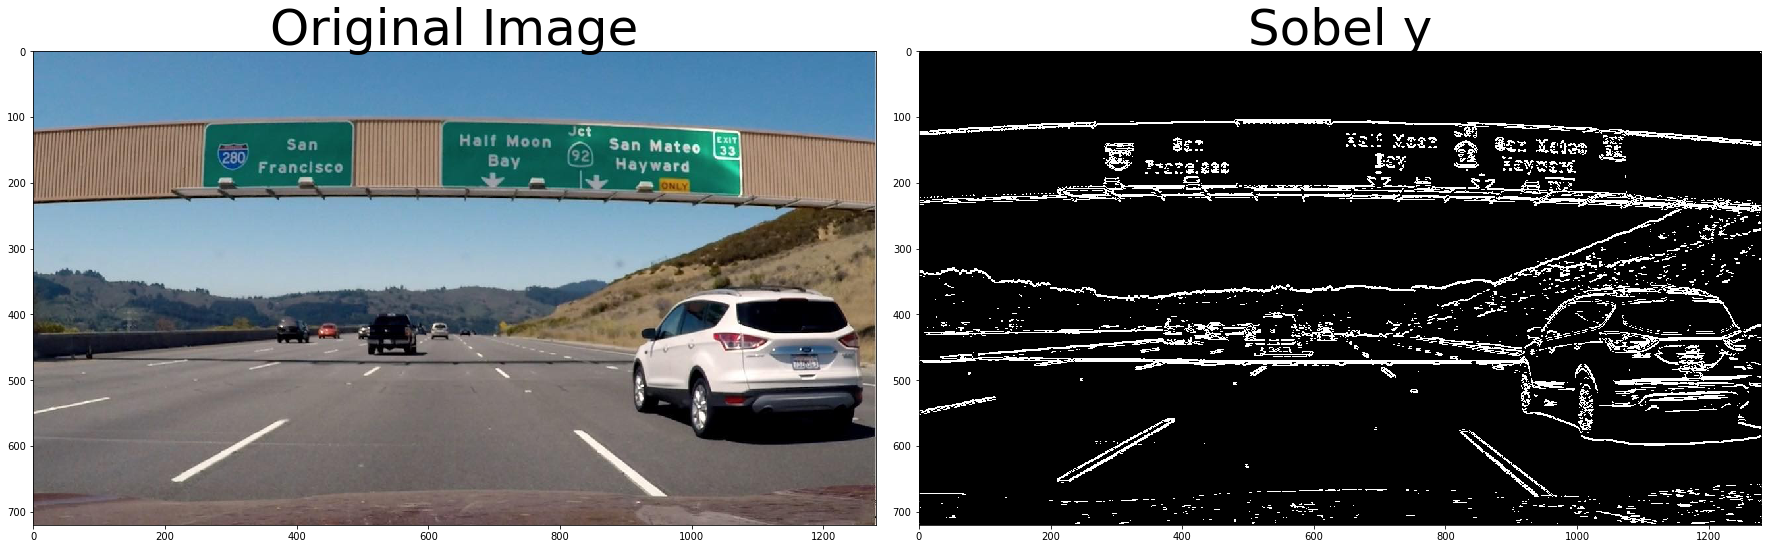

In [11]:
# Read in an image
image = mpimg.imread('test_images/signs_vehicles_xygrad.png')

# Run the function, y orientation
grad_binary = abs_sobel_thresh(image, orient='y', thresh_min=20, thresh_max=100)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Sobel y', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Magnitude and Gradient

In [12]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    # Return the binary image
    return binary_output

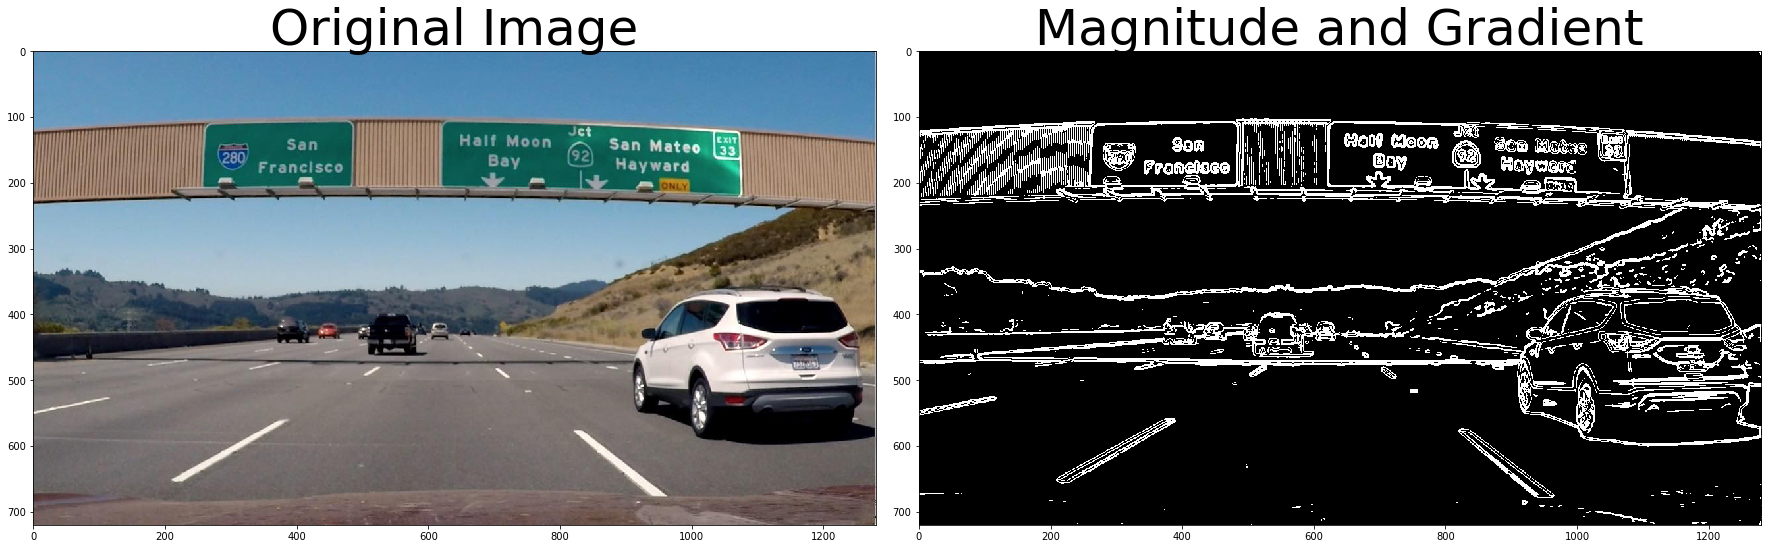

In [13]:
# Read in an image
image = mpimg.imread('test_images/signs_vehicles_xygrad.png')

# Run the function
mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Magnitude and Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Direction of the Gradient

In [14]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

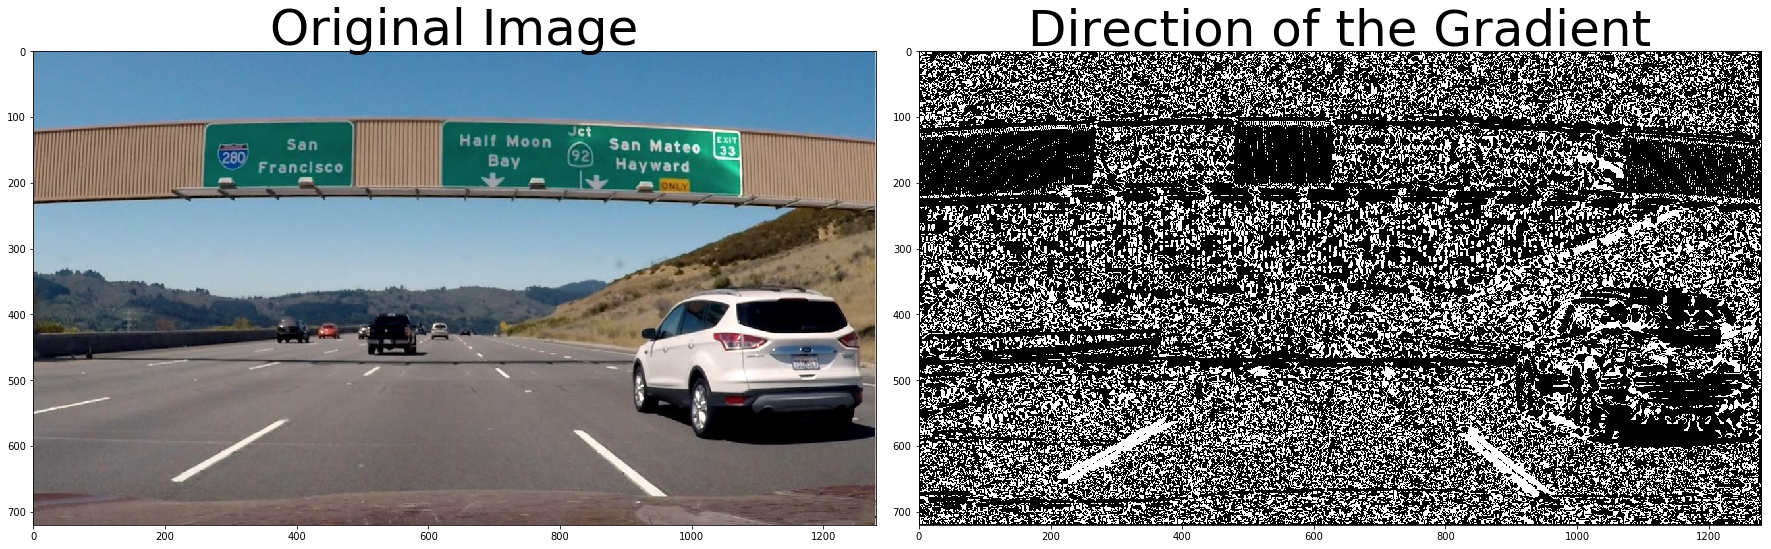

In [15]:
# Read in an image
image = mpimg.imread('test_images/signs_vehicles_xygrad.png')

# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Direction of the Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## HLS and Color Thresholds

In [16]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

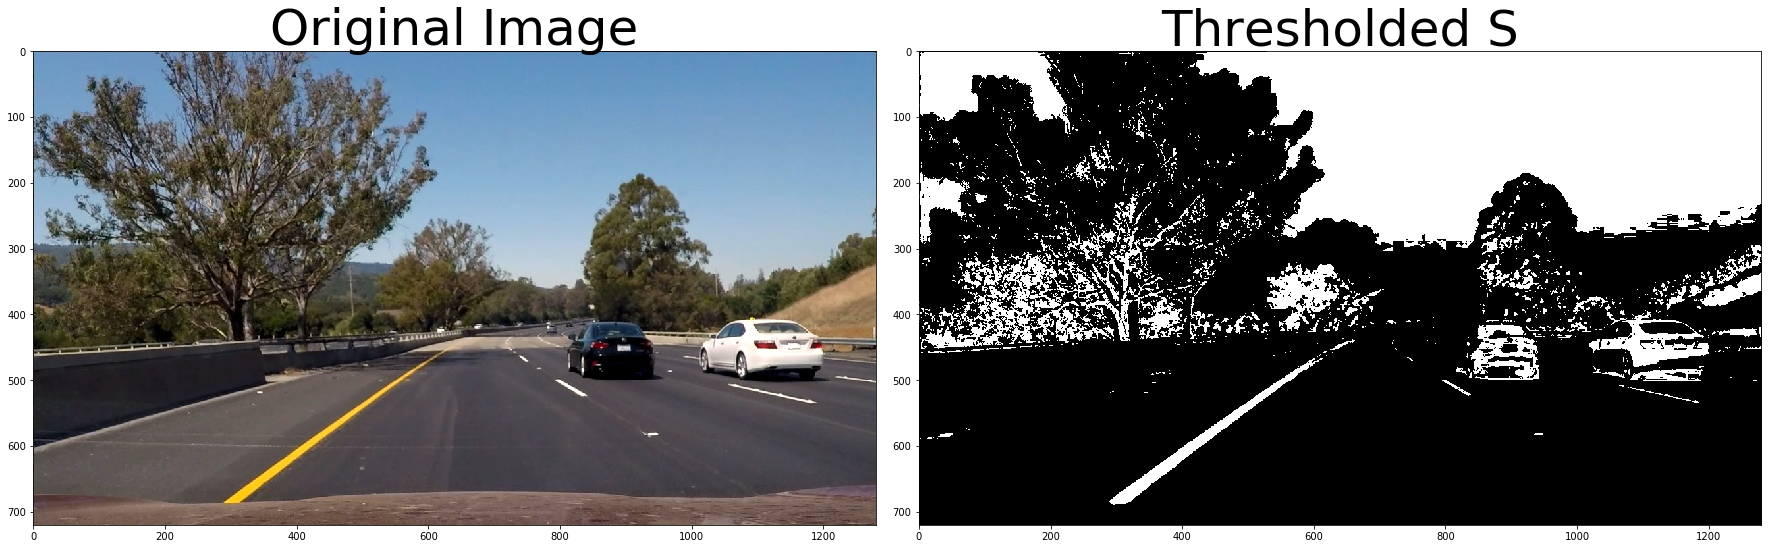

In [17]:
# Read in an image
image = mpimg.imread('test_images/test6.jpg') 

hls_binary = hls_select(image, thresh=(90, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Color and Gradient

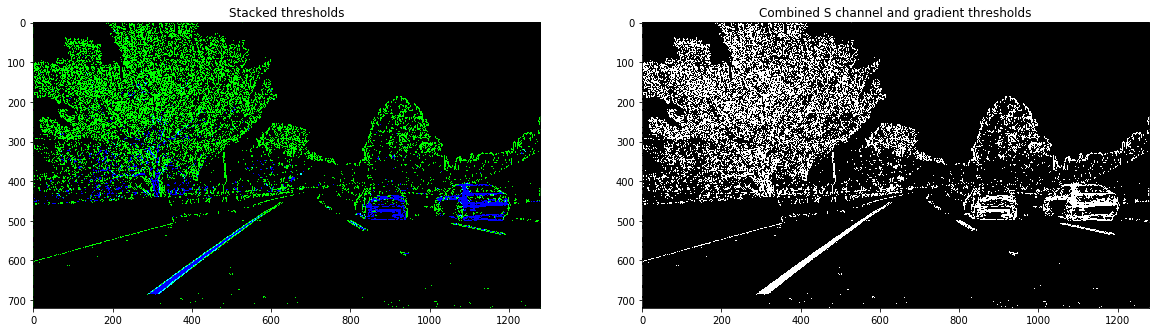

In [18]:
# Read in an image
img = mpimg.imread('test_images/test6.jpg') 

# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

## Perspective Transform

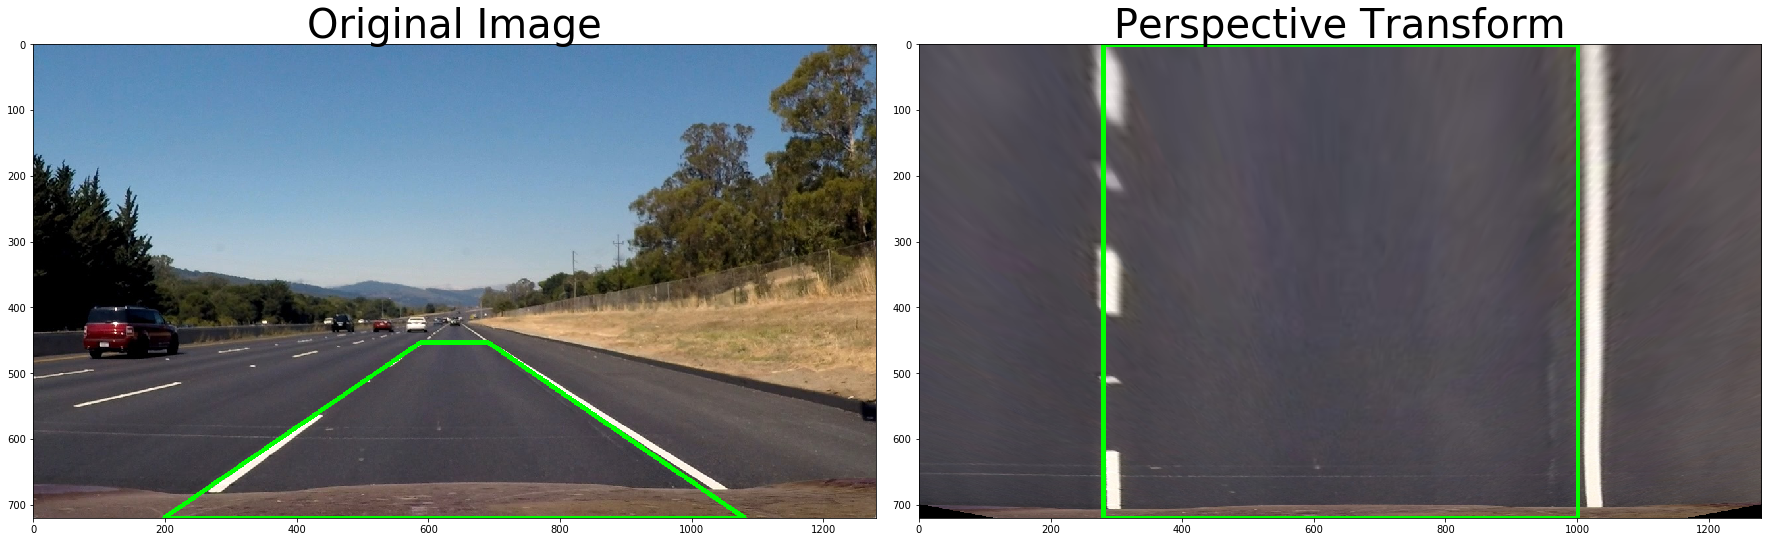

In [19]:
# Read in an image
image = mpimg.imread('test_images/straight_lines2.jpg')

img_size = (image.shape[1], image.shape[0])

height = img.shape[0]
width = img.shape[1]

x_top_left = width * 0.46
x_top_right = width * 0.54
y_top = height * 0.63

x_bottom_left = width * 0.155
x_bottom_right = width * 0.845
y_bottom = height

corners_src = np.array([[[x_top_left, y_top]],\
                        [[x_top_right, y_top]],\
                        [[x_bottom_left, y_bottom]],\
                        [[x_bottom_right, y_bottom]]])
vertices_src = np.array([[(x_top_left, y_top),\
                          (x_top_right, y_top), \
                          (x_bottom_right, y_bottom),\
                          (x_bottom_left, y_bottom)]], dtype=np.int32)

top = 0
bottom = 720
left = (int)(width/2 - height/2)
right = (int)(width/2 + height/2)

corners_dst = np.array([[[left, top]],\
                        [[right, top]],\
                        [[left, bottom]],\
                        [[right, bottom]]])
vertices_dst = np.array([[(left, top),\
                          (right, top), \
                          (right, bottom),\
                          (left, bottom)]], dtype=np.int32)

src = np.float32([corners_src[0], corners_src[1], corners_src[2], corners_src[3]])
dst = np.float32([corners_dst[0], corners_dst[1], corners_dst[2], corners_dst[3]])

# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)

# Warp the image using OpenCV warpPerspective()
result = cv2.warpPerspective(image, M, img_size)

# Draw mask
cv2.polylines(image, vertices_src, True, color=[0, 255, 0], thickness=5)
cv2.polylines(result, vertices_dst, True, color=[0, 255, 0], thickness=5)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Perspective Transform', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [20]:
print(src)
print(dst)

[[[ 588.8  453.6]]

 [[ 691.2  453.6]]

 [[ 198.4  720. ]]

 [[1081.6  720. ]]]
[[[ 280.    0.]]

 [[1000.    0.]]

 [[ 280.  720.]]

 [[1000.  720.]]]


## Binary Warped Image

In [21]:
def compute_binary_warped(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    image = np.copy(img)
    
    # Undistort image
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    img_size = (combined_binary.shape[1], combined_binary.shape[0])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(combined_binary, M, img_size)
    
    return warped

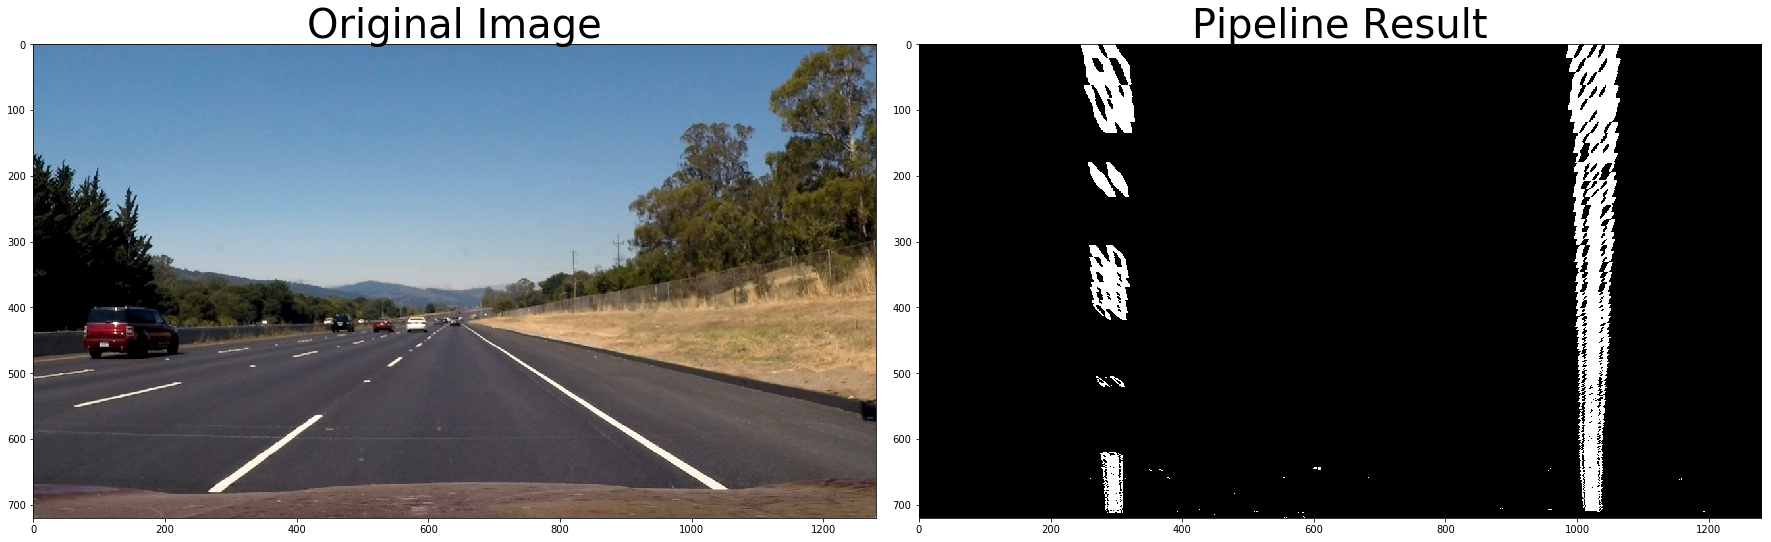

In [22]:
# Read in an image
image = mpimg.imread('test_images/straight_lines2.jpg')

binary_warped = compute_binary_warped(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Find the Lines

In [23]:
def first_window_search(window_image):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(window_image[int(window_image.shape[0]/2):,:], axis=0)

    # Create an output image to draw on and  visualize the result
    #out_img = np.zeros_like(window_image)
    out_img = np.dstack((window_image, window_image, window_image))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(window_image.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = window_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = window_image.shape[0] - (window+1)*window_height
        win_y_high = window_image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return out_img, left_fit, right_fit

(720, 0)

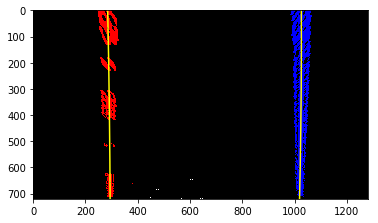

In [24]:
line_image, left_fit, right_fit = first_window_search(binary_warped)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(line_image)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [25]:
def window_search(window_image, left_fit, right_fit):
    nonzero = window_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + \
                                   left_fit[1]*nonzeroy + \
                                    left_fit[2] - margin)) & \
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + \
                                   left_fit[1]*nonzeroy + \
                                   left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + \
                                    right_fit[1]*nonzeroy + \
                                    right_fit[2] - margin)) & \
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + \
                                    right_fit[1]*nonzeroy + \
                                    right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, window_image.shape[0]-1, window_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((window_image, window_image, window_image))*255
    
    inner_margin = 10
    inner_window1 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+inner_margin, ploty])))])
    inner_window2 = np.array([np.transpose(np.vstack([right_fitx-inner_margin, ploty]))])
    inner_window_pts = np.hstack((inner_window1, inner_window2))
    cv2.fillPoly(out_img, np.int_([inner_window_pts]), (0,255, 0))
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img, left_fit, right_fit, leftx, lefty, rightx, righty



(720, 0)

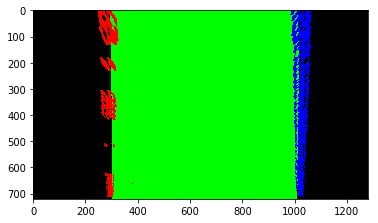

In [26]:
line_image, left_fit, right_fit, leftx, lefty, rightx, righty = \
window_search(binary_warped, left_fit, right_fit)

plt.imshow(line_image)
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Measure Curvature

In [27]:
def measure_curvature(leftx, lefty, rightx, righty):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720  # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [28]:
left_curverad, right_curverad = measure_curvature(leftx, lefty, rightx, righty)

print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

14195.282108981208 m 8795.68544462702 m


## Unwarp Lines

In [29]:
def unwarp_lines(line_image, original_image, left_curverad):
    img_size = (line_image.shape[1], line_image.shape[0])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(dst, src)

    # Warp the image using OpenCV warpPerspective()
    unwarped = cv2.warpPerspective(line_image, M, img_size)
    unwarped = cv2.addWeighted(original_image, 1, unwarped, 0.4, 0)
    
    text = "Radius of Curvature = " + str(int(left_curverad)) + "(m)"
    cv2.putText(unwarped, text, (30,30), cv2.FONT_HERSHEY_SIMPLEX, 1, color=[255, 255, 255], thickness=2)
    
    return unwarped

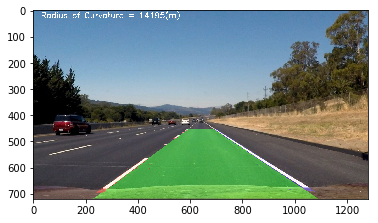

In [30]:
unwarped = unwarp_lines(line_image, image, left_curverad)
plt.imshow(unwarped)

In [31]:
def find_offset(unwarped, leftx, rightx):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Assuming camera is mounted in center of car
    image_midpoint = unwarped.shape[1]/2
    
    car_midpoint = (leftx[0] + rightx[len(rightx)-1])/2
    car_midpoint = abs(car_midpoint - image_midpoint)
    car_midpoint = car_midpoint * xm_per_pix
    
    text = "Vehicle is = " + str("{0:.2f}".format(car_midpoint)) + "m left of center"
    cv2.putText(unwarped, text, (30,60), cv2.FONT_HERSHEY_SIMPLEX, 1, color=[255, 255, 255], thickness=2)
    return unwarped

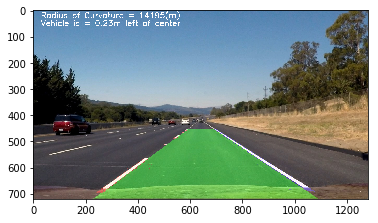

In [32]:
offset_image = find_offset(unwarped, leftx, rightx)
plt.imshow(offset_image)

In [33]:
first_loop = True
left_fit = []
right_fit = []

In [34]:
def process_image(image):
    binary_warped = compute_binary_warped(image)
    global first_loop
    global left_fit
    global right_fit
    if first_loop == True:
        line_image, left_fit, right_fit = first_window_search(binary_warped)
        first_loop = False
    else:
        line_image, left_fit, right_fit, leftx, lefty, rightx, righty = \
        window_search(binary_warped, left_fit, right_fit)
        left_curverad, right_curverad = measure_curvature(leftx, lefty, rightx, righty)
        unwarped_image = unwarp_lines(line_image, image, left_curverad)
        image = find_offset(unwarped_image, leftx, rightx)
        
    return image    

In [35]:
first_loop = True
left_fit = []
right_fit = []

project_video_output = 'output_images/project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4


100%|█████████▉| 1260/1261 [02:53<00:00,  7.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

CPU times: user 3min 27s, sys: 42.4 s, total: 4min 9s
Wall time: 2min 54s


In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

In [37]:
first_loop = True
left_fit = []
right_fit = []

challenge_video_output = 'output_images/challenge_video_output.mp4'
clip2 = VideoFileClip("challenge_video.mp4")
challenge_video_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_video_clip.write_videofile(challenge_video_output, audio=False)

[MoviePy] >>>> Building video output_images/challenge_video_output.mp4
[MoviePy] Writing video output_images/challenge_video_output.mp4


100%|██████████| 485/485 [01:02<00:00,  7.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge_video_output.mp4 

CPU times: user 1min 16s, sys: 15.8 s, total: 1min 32s
Wall time: 1min 3s


In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_video_output))

In [39]:
first_loop = True
left_fit = []
right_fit = []

harder_challenge_video_output = 'output_images/harder_challenge_video_output.mp4'
clip3 = VideoFileClip("harder_challenge_video.mp4")
harder_challenge_video_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!
%time harder_challenge_video_clip.write_videofile(harder_challenge_video_output, audio=False)

[MoviePy] >>>> Building video output_images/harder_challenge_video_output.mp4
[MoviePy] Writing video output_images/harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [02:58<00:00,  6.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/harder_challenge_video_output.mp4 

CPU times: user 3min 30s, sys: 42.1 s, total: 4min 12s
Wall time: 2min 59s


In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_video_output))